In [1]:
# coding=utf-8
from scapy.all import *
import binascii
import struct
import time

import crcmod
import libnum

from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether

import numpy as np

plc_cube = []
hmi_cube = []

def packet_analysis(pkt):
    if TCP in pkt:
        #print(pkt[TCP].dport)
        #print(len(pkt[TCP].payload))
        if len(pkt[TCP].payload) > 6:
            d_time = float(str(pkt.time))
            #print(type(d_time))
            #print(dir(pkt[TCP]))
            #print(pkt.summary())
            #print(pkt.time)
            #print(binascii.hexlify(bytes(pkt[TCP].payload))[12:])
            #print(type(float(pkt.time)))
            if(pkt[TCP].dport == 502):
                #plc_cube.append([d_time,binascii.hexlify(bytes(pkt[TCP].payload))[12:]])
                plc_cube.append(d_time)
            else:
                #hmi_cube.append([d_time,binascii.hexlify(bytes(pkt[TCP].payload))[12:]])
                hmi_cube.append(d_time)


In [2]:
try:
    #print(ifaces)
    #sniff(iface="Realtek PCIe GbE Family Controller", prn=packet_analysis, filter="udp port 18507")
    sniff(offline='DataSet/modbus_normal_oper001.pcapng', prn=packet_analysis, store=0)
    plc_cube = np.asarray(plc_cube)
    hmi_cube = np.asarray(hmi_cube)
    print('Completed')

except Exception as sniff_dec_err:
    traceback.print_exc()
    print(str(sniff_dec_err))

Completed


In [3]:
print(hmi_cube.shape)
print(plc_cube.shape)

(3110,)
(3110,)


In [4]:
print(hmi_cube)

[1.61409126e+09 1.61409126e+09 1.61409126e+09 ... 1.61409181e+09
 1.61409181e+09 1.61409181e+09]


In [5]:
print(plc_cube)

[1.61409126e+09 1.61409126e+09 1.61409126e+09 ... 1.61409181e+09
 1.61409181e+09 1.61409181e+09]


In [6]:
fourier = np.fft.fft(hmi_cube)

In [7]:
timespan = hmi_cube[50] - hmi_cube[0]
print(timespan,'s')

9.073971033096313 s


In [8]:
hmi_diff = np.diff(hmi_cube)

In [9]:
print(hmi_diff)

[0.00598788 0.00600719 0.09997392 ... 0.00497699 0.09148693 0.17351198]


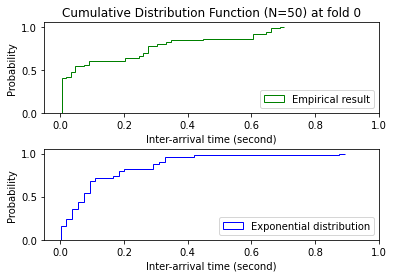

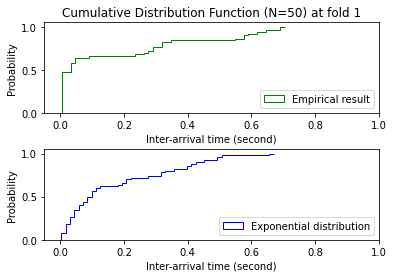

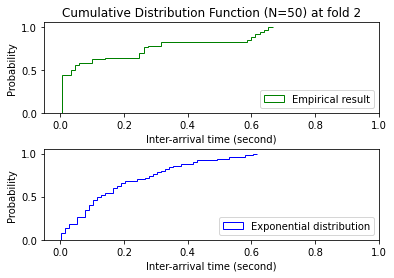

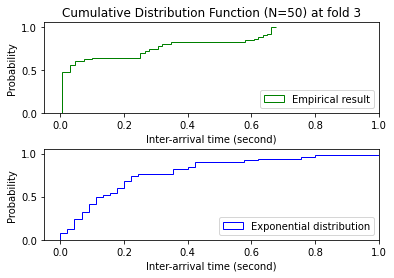

In [10]:

import numpy as np
import matplotlib.pyplot as plt

#fig1, ax = plt.subplots()
for k in range(4):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.subplots_adjust(hspace=0.4)

    #### First, plot the empirical result
    fold = k*50
    y = hmi_diff[fold:fold+50]
    n_bins = len(y)-1
    n, bins, patches = ax1.hist(y, n_bins, density=True, histtype='step',
              cumulative=True, label='Empirical result', color='g')
    # the following line is used to remove the last point
    patches[0].set_xy(patches[0].get_xy()[:-1])
    ax1.set_xlim(-0.05, 1.0)
    ax1.set_xlabel('Inter-arrival time (second)')
    ax1.set_ylabel('Probability')
    ax1.set_title('Cumulative Distribution Function (N='+ str(len(y)) +') at fold ' + str(k))
    ax1.legend(loc=4)

    #### Then plot the theoretical expontential distribution
    G = np.random.default_rng()
    y = G.exponential(scale=0.2, size=len(y))
    # Now, plot the cumulative distributioin function (CDF)
    n_bins = len(y)-1
    n, bins, patches = ax2.hist(y, n_bins, density=True, histtype='step',
              cumulative=True, label='Exponential distribution', color='b')
    # the following line is used to remove the last point
    patches[0].set_xy(patches[0].get_xy()[:-1])
    ax2.set_xlim(-0.05, 1.0)
    ax2.set_xlabel('Inter-arrival time (second)')
    ax2.set_ylabel('Probability')
    #ax2.set_title('Cumulative Distribution Function (N=100)')
    ax2.legend(loc=4)

plt.show()
#plt.savefig('./cdf.pdf')

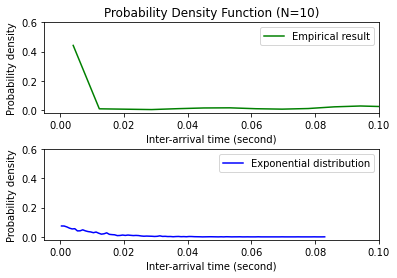

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.4)

#### First, plot the p.d.f. of our empirical result
y = hmi_diff
heights, bins = np.histogram(y, bins=100)
# do normalization
heights = heights/float(sum(heights))
binMids = bins[:-1]+np.diff(bins)/2.
ax1.plot(binMids, heights, label='Empirical result', color='g')
ax1.set_xlim(-0.005, 0.1)
ax1.set_ylim(-0.02,0.6)
ax1.set_xlabel('Inter-arrival time (second)')
ax1.set_ylabel('Probability density')
ax1.set_title('Probability Density Function (N=10)')
ax1.legend(loc=1)

#### Now, plot the p.d.f. of exponential distribution
G = np.random.default_rng()
y = G.exponential(scale=0.01, size=len(y))
heights, bins = np.histogram(y, bins=100)
# do normalization
heights = heights/float(sum(heights))
binMids = bins[:-1]+np.diff(bins)/2.
ax2.plot(binMids, heights, label='Exponential distribution', color='b')
ax2.set_xlim(-0.005, 0.1)
ax2.set_ylim(-0.02, 0.6)
ax2.set_xlabel('Inter-arrival time (second)')
ax2.set_ylabel('Probability density')
ax2.legend(loc=1)

plt.show()


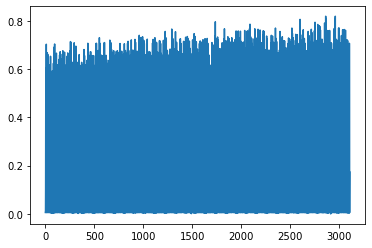

In [12]:
plt.plot(hmi_diff)
plt.show()

In [13]:
freqs = np.fft.fftfreq(len(hmi_diff))

In [14]:
for coef,freq in zip(fourier,freqs):
    if coef:
        print('{c:>6} * exp(2 pi i t * {f})'.format(c=coef,f=freq))

(5019824669844.743+8.726119995117188e-05j) * exp(2 pi i t * 0.0)
(91.61668400208487+273418.4785812341j) * exp(2 pi i t * 0.000321646831778707)
(-2.4826032139794734+136564.91317098256j) * exp(2 pi i t * 0.000643293663557414)
(81.28089800414807+91115.7882598865j) * exp(2 pi i t * 0.0009649404953361209)
(79.47025191401656+68183.75033373028j) * exp(2 pi i t * 0.001286587327114828)
(-1266.6503732625847+54994.72899396968j) * exp(2 pi i t * 0.0016082341588935349)
(-246.84576191817587+45526.996164987875j) * exp(2 pi i t * 0.0019298809906722419)
(-218.52289908596276+39007.61954662209j) * exp(2 pi i t * 0.002251527822450949)
(-288.0122451271609+34163.239942052256j) * exp(2 pi i t * 0.002573174654229656)
(-259.1028941344398+30398.68671209761j) * exp(2 pi i t * 0.0028948214860083626)
(-208.40416355534353+27138.572609999235j) * exp(2 pi i t * 0.0032164683177870698)
(-228.618222178206+24820.72560833946j) * exp(2 pi i t * 0.003538115149565777)
(-231.91194418946225+22752.5183856601j) * exp(2 pi i t * 

(-276.9628887445043+63.37547680515895j) * exp(2 pi i t * 0.4261820521067867)
(-273.4939795546291+66.2266291604564j) * exp(2 pi i t * 0.42650369893856543)
(-280.6124315842434+66.0866586944709j) * exp(2 pi i t * 0.42682534577034414)
(-276.4019217733654+60.632529799721844j) * exp(2 pi i t * 0.42714699260212285)
(-279.5975518477031+61.743232174267206j) * exp(2 pi i t * 0.42746863943390156)
(-274.6090566422431+63.68040028012537j) * exp(2 pi i t * 0.4277902862656803)
(-279.7651367688026+68.74998976323803j) * exp(2 pi i t * 0.428111933097459)
(-277.96940149850775+64.72574614375108j) * exp(2 pi i t * 0.4284335799292377)
(-274.1394298408164+63.658225003827795j) * exp(2 pi i t * 0.4287552267610164)
(-279.4350238067999+65.32807362452249j) * exp(2 pi i t * 0.4290768735927951)
(-280.20619228277576+56.440234701723384j) * exp(2 pi i t * 0.4293985204245738)
(-274.88491984624767+61.178816295263694j) * exp(2 pi i t * 0.42972016725635254)
(-276.66014413431856+56.21116272586147j) * exp(2 pi i t * 0.430041

(-268.8434150600069-482.5940723425107j) * exp(2 pi i t * -0.16307494371180445)
(-289.67761460248266-488.29811266348287j) * exp(2 pi i t * -0.16275329688002574)
(-285.8539237906941-493.10895616966593j) * exp(2 pi i t * -0.16243165004824703)
(-276.67239997933416-484.32113221493154j) * exp(2 pi i t * -0.16211000321646832)
(-281.8902174856634-490.12736587327896j) * exp(2 pi i t * -0.1617883563846896)
(-282.70104241559693-495.0538023371372j) * exp(2 pi i t * -0.1614667095529109)
(-284.19502568462195-509.7835592132378j) * exp(2 pi i t * -0.1611450627211322)
(-275.4840160764547-504.38202301420057j) * exp(2 pi i t * -0.16082341588935348)
(-282.7492983597447-501.5314983007546j) * exp(2 pi i t * -0.1605017690575748)
(-281.4137091421747-499.33284074042035j) * exp(2 pi i t * -0.16018012222579608)
(-279.0093681117777-502.9289542825852j) * exp(2 pi i t * -0.15985847539401737)
(-269.26904504930826-492.05739271274047j) * exp(2 pi i t * -0.15953682856223866)
(-277.63019144116265-490.8793733577128j) * e